In [ ]:
# Node Graphs

In [16]:
# import libraries
import re
import pandas as pd
import numpy as np
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from IPython import display
import networkx.algorithms.approximation as nx_app
import math
from tqdm import tqdm
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

**1. Basic network Chart**

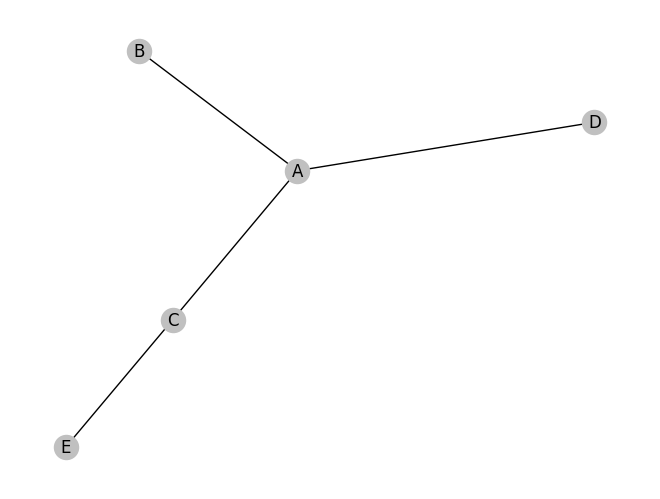

In [2]:
# Build a dataframe with 4 connections
df = pd.DataFrame({ 'from':['A', 'B', 'C','A'], 'to':['D', 'A', 'E','C']})

# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')

# Plot it
nx.draw(G, with_labels=True, node_color="silver",node_shape="o")
plt.show()

**2. Custom Network**

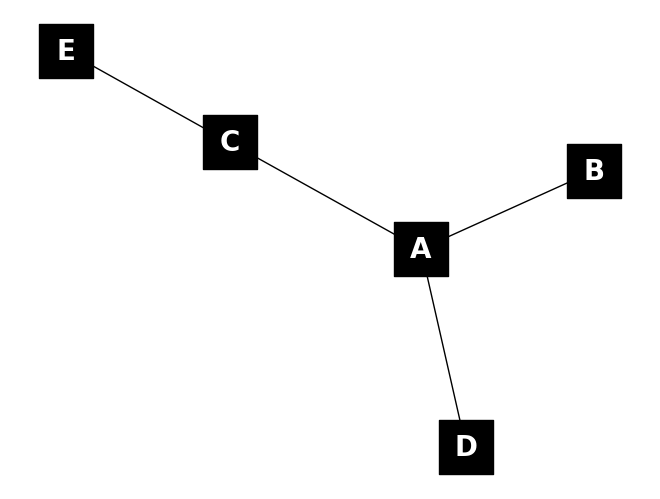

In [3]:
# Build a dataframe with your connections
df = pd.DataFrame({ 'from':['A', 'B', 'C','A'], 'to':['D', 'A', 'E','C']})

# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')

# Custom the labels:
nx.draw(G, with_labels=True, node_size=1500,node_color="k", font_size=20,node_shape="s", font_color="w", font_weight="bold")
plt.show()

**3. Basic netgraph**

In [4]:
pip install netgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.3/339.3 kB 20.8 MB/s eta 0:00:00


In [5]:
from netgraph import Graph

In [41]:
# Create a modular graph (dummy data)
partition_sizes = [10, 20, 30, 40]
g = nx.random_partition_graph(partition_sizes, 0.5, 0.1)

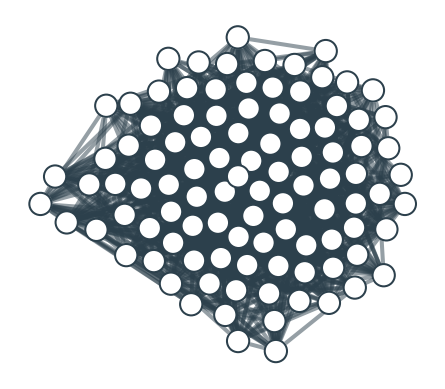

In [42]:
%%capture --no-display
# ^ Hide annoying warning for this cell
# Build graph
Graph(g)

In [43]:
# Create a dictionary mapping nodes to their community.
# This information is used position nodes according to their community
# when using the `community` node layout in netgraph.
# There is only 10 Tableau colors
node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1


# Color nodes according to their community.
community_to_color = {
    0 : 'black',
    1 : 'grey',
    2 : 'tan',
    3 : 'silver',
}


node_color = {node: community_to_color[community_id] \
              for node, community_id in node_to_community.items()}

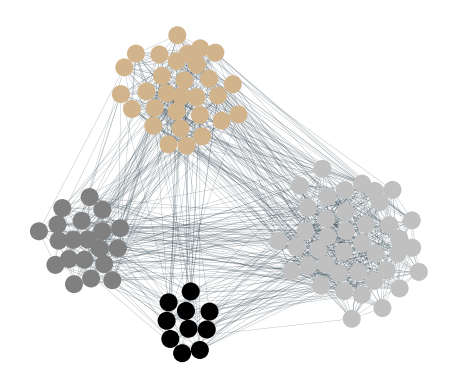

In [44]:
fig, ax = plt.subplots()
Graph(g,
      node_color=node_color, # indicates the community each belongs to
      node_edge_width=0,     # no black border around nodes
      edge_width=0.1,        # use thin edges, as they carry no information in this visualisation
      edge_alpha=0.5,        # low edge alpha values accentuates bundles as they appear darker than single edges
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax,
)
plt.show()

**4. Netgraph animation A**

In [10]:
from matplotlib.animation import FuncAnimation

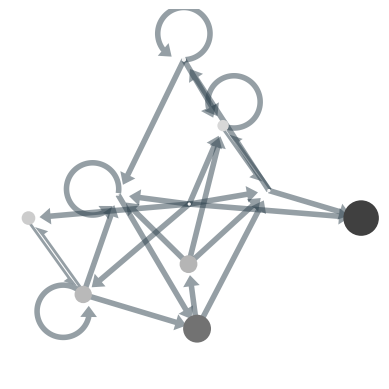

In [11]:
# Simulate a dynamic network with
# - 5 frames / different node states,
# - with 10 nodes at each time point, and
# - an expected edge density of 25%.
total_frames = 5
total_nodes = 10
adjacency_matrix = np.random.rand(total_nodes, total_nodes) < 0.25
node_values = np.random.rand(total_frames, total_nodes)

cmap = plt.cm.Greys

fig, ax = plt.subplots()
g = Graph(adjacency_matrix, edge_width=1.5, arrows=True, ax=ax)
ax.axis([0, 1, 0, 1])

def update(ii):
    for node, artist in g.node_artists.items():
        value = node_values[ii, node]
        artist.set_facecolor(cmap(value))
        artist.set_edgecolor(cmap(value))
        # The default node size is 3., which is rescaled internally
        # to 0.03 to yield layouts comparable to networkx and igraph.
        # As the expectation of `value` is 0.5, we multiply `value` by 6 * 0.01,
        # and thus match the default node size on average.
        artist.radius = 6 * 0.01 * value
    return g.node_artists.values()

ani = FuncAnimation(fig, update, frames=total_frames, interval=200, blit=True)

In [15]:
fig.suptitle('Netgraph animation Dynamic Nodes', fontsize=14)

# converting to an html5 video
video = ani.to_html5_video()

# embedding for the video
html = display.HTML(video)

# draw the animation
display.display(html)
plt.close()

**5. Netgraph animation B**

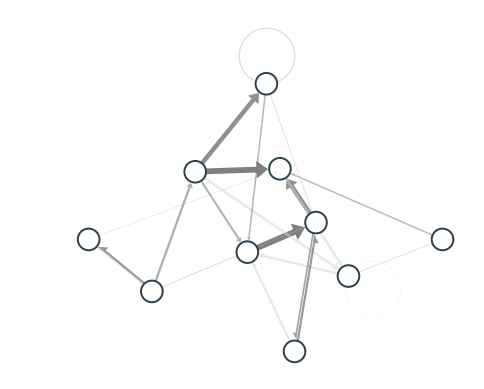

In [19]:
# Simulate a dynamic network with
# - 5 frames / network states,
# - with 10 nodes at each time point,
# - an expected edge density of 25%, and
# - edge weights drawn from a Gaussian distribution.
total_frames = 5
total_nodes = 10
adjacency_matrix = np.random.rand(total_nodes, total_nodes) < 0.25
weight_matrix = np.random.randn(total_frames, total_nodes, total_nodes)

# Normalise the weights, such that they are on the interval [0, 1].
# They can then be passed directly to matplotlib colormaps (which expect floats on that interval).
vmin, vmax = -2, 2
weight_matrix[weight_matrix<vmin] = vmin
weight_matrix[weight_matrix>vmax] = vmax
weight_matrix -= vmin
weight_matrix /= vmax - vmin

cmap = plt.cm.Greys

fig, ax = plt.subplots()
g = Graph(adjacency_matrix, edge_cmap=cmap, arrows=True, ax=ax)

def update(ii):
    artists = []
    for jj, kk in zip(*np.where(adjacency_matrix)):
        w = weight_matrix[ii, jj, kk]
        artist = g.edge_artists[(jj, kk)]
        artist.set_facecolor(cmap(w))
        artist.update_width(0.03 * np.abs(w-0.5)) # np.abs(w-0.5) so that large negative edges are also wide
        artists.append(artist)
    return artists

ani = FuncAnimation(fig, update, frames=total_frames, interval=200, blit=True)

In [20]:
fig.suptitle('Netgraph animation Dynamic Nodes', fontsize=14)

# converting to an html5 video
video = ani.to_html5_video()

# embedding for the video
html = display.HTML(video)

# draw the animation
display.display(html)
plt.close()

**6. Netgraph animation C**

In [13]:
from IPython import display

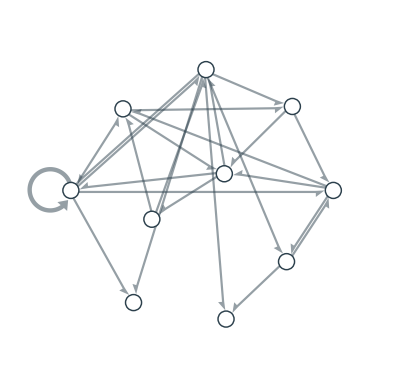

In [21]:
# Simulate a dynamic network with
# - 5 frames / network states,
# - with 10 nodes at each time point,
# - an expected edge density of 25% at each time point
total_frames = 5
total_nodes = 10
adjacency_matrix = np.random.rand(total_frames, total_nodes, total_nodes) < 0.25

fig, ax = plt.subplots()
g = Graph(np.ones((total_nodes, total_nodes)), edge_width=1.5, arrows=True, ax=ax) # initialise with fully connected graph

def update(ii):
    for (jj, kk), artist in g.edge_artists.items():
        # turn visibility of edge artists on or off, depending on the adjacency
        if adjacency_matrix[ii, jj, kk]:
            artist.set_visible(True)
        else:
            artist.set_visible(False)
    return g.edge_artists.values()

ani = FuncAnimation(fig, update, frames=total_frames, interval=200, blit=True)

In [22]:
fig.suptitle('Netgraph animation Dynamic Plot', fontsize=14)

# converting to an html5 video
video = ani.to_html5_video()

# embedding for the video
html = display.HTML(video)

# draw the animation
display.display(html)
plt.close()

**7. NetworkX Colormap**

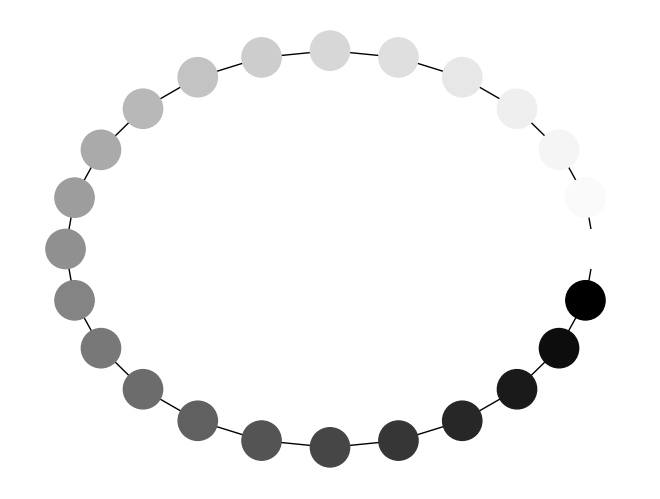

In [23]:
G = nx.cycle_graph(24)
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color=range(24), node_size=800, cmap=plt.cm.Greys)
plt.show()

**8. Travelling Salesman Problem**

https://towardsdatascience.com/solving-the-travelling-salesman-problem-for-germany-using-networkx-in-python-2b181efd7b07/

In [57]:
import networkx.algorithms.approximation as nx_app
import math

The route of the traveller is: [0, 4, 19, 12, 2, 7, 10, 18, 5, 13, 6, 11, 3, 16, 17, 15, 14, 8, 9, 1, 0]


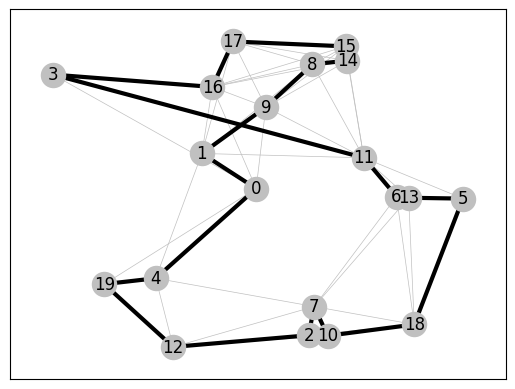

In [59]:
G = nx.random_geometric_graph(20, radius=0.4, seed=3)
pos = nx.get_node_attributes(G, "pos")

# Depot should be at (0,0)
pos[0] = (0.5, 0.5)

H = G.copy()


# Calculating the distances between the nodes as edge's weight.
for i in range(len(pos)):
    for j in range(i + 1, len(pos)):
        dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
        dist = dist
        G.add_edge(i, j, weight=dist)

cycle = nx_app.christofides(G, weight="weight")
edge_list = list(nx.utils.pairwise(cycle))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos, edge_color="silver", width=0.5)

nx.draw_networkx_nodes(
    G,
    pos,
    cmap=plt.cm.Reds_r,
    node_color="silver"
)

# Draw the route
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    edgelist=edge_list,
    edge_color="black",
    node_size=0,
    width=3,
    cmap=plt.cm.Greys
)

print("The route of the traveller is:", cycle)
plt.show()